In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Apr  8 17:40:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import librosa
import librosa.display
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import glob
import torchaudio
import warnings
import os
import pickle
#torch.set_default_tensor_type("torch.cuda.FloatTensor")
gpu = torch.device("cuda:0")
warnings.filterwarnings("ignore", category=UserWarning, module="librosa")

In [3]:
from google.colab import drive
drive.mount("/content/drive")
first = False

if not os.path.exists("/content/ConditionalMelGAN"):
  first = True
  !mkdir "ConditionalMelGAN"
  !find "/content/drive/MyDrive/neural-music/data" -name "*.zip" -exec unzip {} -d data \;
os.chdir("/content/ConditionalMelGAN")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!cp /content/drive/MyDrive/neural-music/ConditionalMelGAN/*.py .

import generate
import generate_csv
import data
import train
import model

In [5]:
directories = ["../data/edm", "../data/classical", "../data/lofi"]
data_config = data.DatasetConfig(num_classes=len(directories))
discrim_layers = [[16, 21, 1, 1], # each is (ouput_filts, kern_sz, stride, groups
                  [32, 22, 4, 4],
                  [64, 22, 4, 16],
                  [128, 22, 4, 16],
                  [256, 22, 4, 32],
                  [832, 6, 2, 64]]
generator_layers = [[512, 4, 4],
                    [128, 4, 4],
                    [32, 8, 2],
                    [1, 8, 2]]         
# gen_layers_1d = [[4, 1],  
#                  [8, 1],   
#                  [24, 2],
#                  [24, 2],
#                  [30, 2],
#                  [28, 1],
#                 ]
tr_config = train.TrainConfig(tr_pct=0.4,va_pct=0.5, noise_sz=128, start_filts=256, save_every=2,
                        d_layers_2d=discrim_layers, layers_2d=generator_layers, discrim_steps=2,)
                       # layers_1d=gen_layers_1d)
if first:
  generate_csv.gen_csv(directories, data_config)

In [6]:
df = pd.read_csv("out.csv")
df["class"] = data.encode_classes(df["class"])
size = len(df)
all_indices = np.arange(size)
np.random.shuffle(all_indices)
df = np.array(df)[all_indices]
#pkl_name = "all_loaders.pkl"

# try:
#   with open(pkl_name, "rb") as p:
#     tr_load, va_load, te_load = pickle.load(p)
# except FileNotFoundError:
#tr_dataset = data.MusicDataset(df[:int(size*tr_config.tr_pct)], data_config)
# va_dataset = data.MusicDataset(df[int(size*tr_config.tr_pct):int(size*tr_config.va_pct)], data_config)
# #te_dataset = data.MusicDataset(df[int(size*tr_config.va_pct):], data_config)

# #tr_load = DataLoader(tr_dataset, batch_size=tr_config.batch_sz, shuffle=True, num_workers=2)
# va_load = DataLoader(va_dataset, batch_size=tr_config.batch_sz, shuffle=True, num_workers=2)
#te_load = DataLoader(te_dataset, batch_size=tr_config.batch_sz, shuffle=True, num_workers=2)

In [7]:
generator = model.Generator(tr_config, data_config).to(gpu)
discriminator = model.Discriminator(tr_config, data_config).to(gpu)
gen_optim = torch.optim.Adam(generator.parameters(), lr=tr_config.learn_rate)
dis_optim = torch.optim.Adam(discriminator.parameters(), lr=tr_config.learn_rate)

Generator Parameters: 24.017M
Discriminator Parameters: 1.201M


In [8]:
torch.backends.cudnn.benchmark = True

In [9]:
#train.train(generator, discriminator, gen_optim, dis_optim, tr_load, va_load, tr_config, gpu, path="/content/drive/MyDrive/neural-music/ConditionalMelGAN/model_checkpoints")

In [10]:
# print(torch.get_default_dtype())
# torch.set_default_tensor_type("torch.cuda.FloatTensor")

In [11]:
#del generate

In [12]:
#generator.save(444,141, gen_optim, path=".")
generator.load("/content/ConditionalMelGAN/gen-256-444-141.000.model", None)

In [13]:
# for samp,cond in va_load:
#   real_mel,_ = train.preprocess(generator, samp, gpu)
#   break

In [14]:
# for spectro,condit in zip(real_mel,cond):
#   generate.invert_and_save(spectro,condit,data_config)
#   print("aosnehuttt")

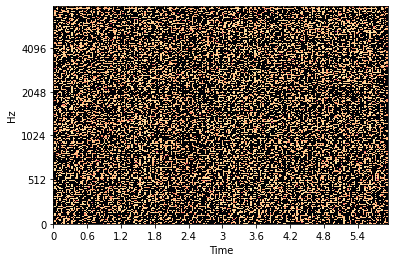

In [15]:
generate.gen_one(0, generator, data_config, gpu)